In [1]:
import trimesh
import collada
import numpy as np
import tf.transformations

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib inline

In [2]:
file_name = "/home/dof6/.gazebo/models/t_shape/meshes/t_shape.dae"

def load_dae_to_trimesh(file_name):
    mesh_data = collada.Collada(filename=file_name)
    unitmeter = mesh_data.assetInfo.unitmeter

    vertex_index_start = 0
    vertices = []
    faces = []

    for geometry in mesh_data.geometries:
        for primitive in geometry.primitives:
            if not isinstance(primitive,collada.triangleset.TriangleSet):
                triangelset = primitive.triangleset()
            else:
                triangelset = primitive
            vertices.append(triangelset.vertex * unitmeter)
            faces.append(triangelset.vertex_index + vertex_index_start)
            vertex_index_start += vertices[-1].shape[0]

    vertices = np.concatenate(vertices,axis=0)
    faces = np.concatenate(faces,axis=0)

    trimesh_data = trimesh.Trimesh(vertices=vertices,faces=faces)
    return trimesh_data, mesh_data

trimesh_data, _ = load_dae_to_trimesh(file_name)

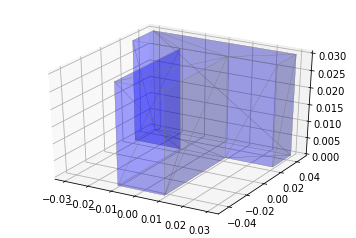

In [3]:
def visualize_trimesh(trimesh_data):
    ax = plt.gca(projection='3d')
    ax.plot_trisurf(trimesh_data.vertices[:, 0], trimesh_data.vertices[:, 1], trimesh_data.vertices[:, 2], triangles=trimesh_data.faces,
                    linewidth=0.2, antialiased=True, color=[0., 0., 1., 0.2], edgecolor='gray')
    return ax

visualize_trimesh(trimesh_data)

In [4]:
contact_r_points, contact_r_faces_indices = trimesh_data.sample(5,return_index=True)
contact_r_face_normals = trimesh_data.face_normals[contact_r_faces_indices,:]

In [5]:
trimesh_data_ray = trimesh.ray.ray_triangle.RayMeshIntersector(trimesh_data)
ray_info = trimesh_data_ray.intersects_id(contact_r_points-0.005*contact_r_face_normals, -contact_r_face_normals, return_locations=True, multiple_hits=False)

In [6]:
ray_indices = ray_info[1]

contact_r_points = contact_r_points[ray_indices,:]
contact_r_faces_indices = contact_r_faces_indices[ray_indices]
contact_r_face_normals = contact_r_face_normals[ray_indices,:]

contact_l_points = ray_info[2]
contact_l_faces_indices = ray_info[0]
contact_l_face_normals = trimesh_data.face_normals[contact_l_faces_indices,:]

In [7]:
gripper_axes = contact_l_points - contact_r_points
gripper_widths = np.sqrt(np.sum(gripper_axes**2,axis=1,keepdims=True))
gripper_axes = gripper_axes/gripper_widths
contact_l_points += 0.001*gripper_axes
contact_r_points -= 0.001*gripper_axes

1.0


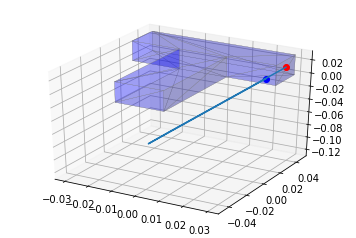

1.0


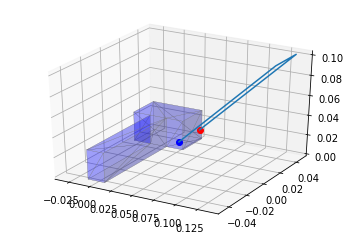

1.0


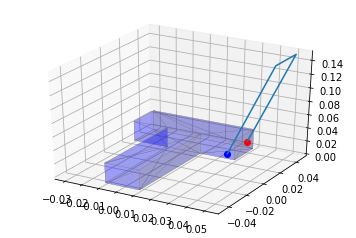

0.0


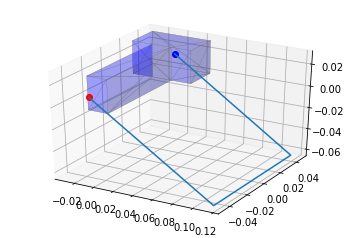

0.0


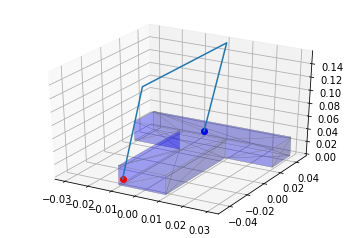

0.0


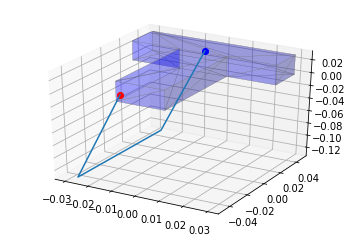

1.0


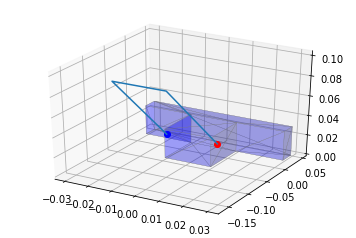

1.0


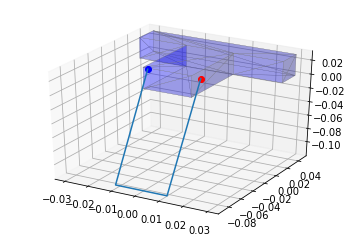

1.0


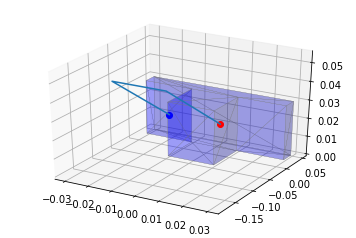

1.0


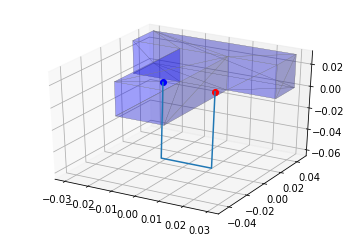

1.0


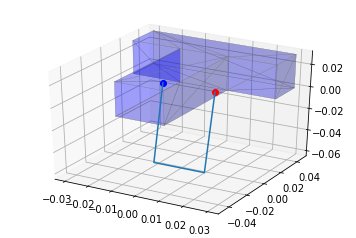

0.0


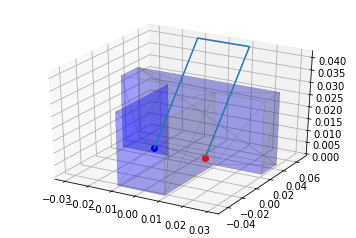

0.0


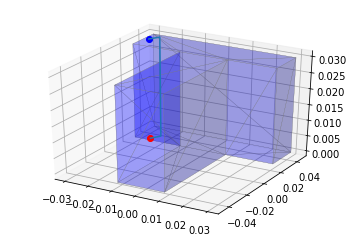

1.0


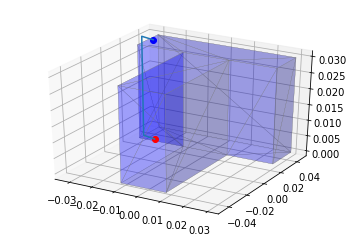

0.0


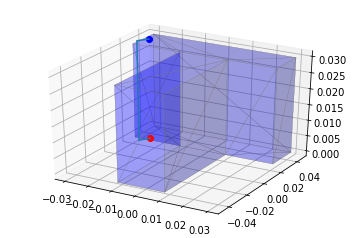

In [8]:
def rotate_quaternion_vector(quaternion, vector):
    return np.matmul(tf.transformations.quaternion_matrix(quaternion)[:3,:3],vector)

contact_c_points = (contact_r_points + contact_l_points)/2.
gripper_width_max = 0.08
gripper_depth_max = 0.15
mu = 0.1
for gripper_width, gripper_axis, contact_l_point, contact_l_face_normal, contact_r_point, contact_r_face_normal in zip(gripper_widths, gripper_axes, contact_l_points, contact_l_face_normals, contact_r_points, contact_r_face_normals):
    rotation_quat = tf.transformations.quaternion_about_axis(2*np.pi*np.random.uniform(), np.random.uniform([3,]))
    approaching_axis0 = np.cross(gripper_axis, np.matmul(tf.transformations.quaternion_matrix(rotation_quat)[:3,:3], gripper_axis))
    for i in range(3):
        rotation_quat = tf.transformations.quaternion_about_axis(2*np.pi*np.random.uniform(), gripper_axis)
        approaching_axis = np.matmul(tf.transformations.quaternion_matrix(rotation_quat)[:3,:3],approaching_axis0)
        
        l_gripper_points = []
        r_gripper_points = []
        for i in range(10):
            r_gripper_points.append(contact_r_point - i/9.*gripper_depth_max*approaching_axis)
        for i in reversed(range(10)):
            l_gripper_points.append(contact_l_point - i/9.*gripper_depth_max*approaching_axis)
        gripper_bar_points = [(r_gripper_points[-1]+l_gripper_points[0])/2.]
        all_gripper_points = r_gripper_points + gripper_bar_points + l_gripper_points 
        all_gripper_points = np.asarray(all_gripper_points)
        sdf_gripper_points = trimesh.proximity.signed_distance(trimesh_data, all_gripper_points)
        
        quality = 1.0
        if gripper_width > gripper_width_max: 
            quality = 0.0
        if np.sqrt(1./(1.+mu**2)) > np.abs(np.sum(gripper_axis*contact_r_face_normal)) and np.sqrt(1./(1.+mu**2)) > np.abs(np.sum(gripper_axis*contact_l_face_normal)):
            quality = 0.0
        if (sdf_gripper_points > 0.).any():
            quality = 0.0
        print(quality)
        
        x_axis = np.cross(gripper_axis, approaching_axis) 
        y_axis = gripper_axis
        z_axis = approaching_axis
        
        gripper_rotation_mtx = np.identity(4)
        gripper_rotation_mtx[:3,0] = x_axis
        gripper_rotation_mtx[:3,1] = y_axis
        gripper_rotation_mtx[:3,2] = z_axis
        gripper_quaternion = tf.transformations.quaternion_from_matrix(gripper_rotation_mtx)
        
        plt.figure()
        ax = visualize_trimesh(trimesh_data)
        ax.plot([contact_l_point[0]], [contact_l_point[1]], [contact_l_point[2]], 'bo')
        ax.plot([contact_r_point[0]], [contact_r_point[1]], [contact_r_point[2]], 'ro')
        ax.plot(all_gripper_points[:,0], all_gripper_points[:,1], all_gripper_points[:,2])
        plt.show()

In [16]:
def sample_antipodal_grasp(mesh, number_of_contact=100, number_of_quaternion=5, gripper_width_max=0.08, gripper_depth_max=0.15, mu=0.1):
    contact_r_points, contact_r_faces_indices = trimesh_data.sample(number_of_contact,return_index=True)
    contact_r_face_normals = trimesh_data.face_normals[contact_r_faces_indices,:]
    
    trimesh_data_ray = trimesh.ray.ray_triangle.RayMeshIntersector(trimesh_data)
    ray_info = trimesh_data_ray.intersects_id(contact_r_points-0.005*contact_r_face_normals, -contact_r_face_normals, return_locations=True, multiple_hits=False)
    ray_indices = ray_info[1]

    contact_r_points = contact_r_points[ray_indices,:]
    contact_r_faces_indices = contact_r_faces_indices[ray_indices]
    contact_r_face_normals = contact_r_face_normals[ray_indices,:]

    contact_l_points = ray_info[2]
    contact_l_faces_indices = ray_info[0]
    contact_l_face_normals = trimesh_data.face_normals[contact_l_faces_indices,:]
    
    gripper_axes = contact_l_points - contact_r_points
    gripper_widths = np.sqrt(np.sum(gripper_axes**2,axis=1,keepdims=True))
    gripper_axes = gripper_axes/gripper_widths
    contact_l_points += 0.001*gripper_axes
    contact_r_points -= 0.001*gripper_axes
    
    gripper_contact_list = []
    gripper_quaternion_list = []
    gripper_width_list = []
    extra_information_list = []
    quality_list = []
    
    for gripper_width, gripper_axis, contact_l_point, contact_l_face_normal, contact_r_point, contact_r_face_normal in zip(gripper_widths, gripper_axes, contact_l_points, contact_l_face_normals, contact_r_points, contact_r_face_normals):
        contact_c_point = (contact_r_point + contact_l_point)/2.
        
        rotation_quat = tf.transformations.quaternion_about_axis(2*np.pi*np.random.uniform(), np.random.uniform([3,]))
        approaching_axis0 = np.cross(gripper_axis, np.matmul(tf.transformations.quaternion_matrix(rotation_quat)[:3,:3], gripper_axis))
        for i in range(number_of_quaternion):
            rotation_quat = tf.transformations.quaternion_about_axis(2*np.pi*i/(number_of_quaternion-1), gripper_axis)
            approaching_axis = np.matmul(tf.transformations.quaternion_matrix(rotation_quat)[:3,:3],approaching_axis0)
            approaching_axis = approaching_axis/np.sqrt(np.sum(approaching_axis**2))

            l_gripper_points = []
            r_gripper_points = []
            for i in range(10):
                r_gripper_points.append(contact_r_point - i/9.*gripper_depth_max*approaching_axis)
            for i in reversed(range(10)):
                l_gripper_points.append(contact_l_point - i/9.*gripper_depth_max*approaching_axis)
            gripper_bar_points = [(r_gripper_points[-1]+l_gripper_points[0])/2.]
            all_gripper_points = r_gripper_points + gripper_bar_points + l_gripper_points 
            all_gripper_points = np.asarray(all_gripper_points)
            sdf_gripper_points = trimesh.proximity.signed_distance(trimesh_data, all_gripper_points)

            quality = 1.0
            if gripper_width > gripper_width_max: 
                quality = 0.0
            if np.sqrt(1./(1.+mu**2)) > np.abs(np.sum(gripper_axis*contact_r_face_normal)) and np.sqrt(1./(1.+mu**2)) > np.abs(np.sum(gripper_axis*contact_l_face_normal)):
                quality = 0.0
            if (sdf_gripper_points > 0.).any():
                quality = 0.0
            print("1",quality)
            x_axis = np.cross(gripper_axis, approaching_axis) 
            y_axis = gripper_axis
            z_axis = approaching_axis

            gripper_rotation_mtx = np.identity(4)
            gripper_rotation_mtx[:3,0] = x_axis
            gripper_rotation_mtx[:3,1] = y_axis
            gripper_rotation_mtx[:3,2] = z_axis
            gripper_quaternion = tf.transformations.quaternion_from_matrix(gripper_rotation_mtx)
            
            extra_information = {
                'contact_r_point' : contact_r_point, 
                'contact_l_point' : contact_l_point, 
                'all_gripper_points' : all_gripper_points,
                'approaching_axis' : approaching_axis,
                'gripper_axis' : gripper_axis
            }
            
            gripper_contact_list.append(contact_c_point)
            gripper_quaternion_list.append(gripper_quaternion)
            gripper_width_list.append(gripper_width)
            extra_information_list.append(extra_information)
            quality_list.append(quality)
            
            rot_quaternion = tf.transformations.quaternion_about_axis(0.0,approaching_axis)
            contact_c_point = (contact_r_point+contact_l_point)/2.
            contact_r_point = rotate_quaternion_vector(rot_quaternion, contact_r_point-contact_c_point) + contact_c_point
            contact_l_point = rotate_quaternion_vector(rot_quaternion, contact_l_point-contact_c_point) + contact_c_point

            closest_points, _, triangle_id = trimesh.proximity.closest_point(trimesh_data,[contact_r_point, contact_l_point])
            contact_r_point = closest_points[0]
            contact_l_point = closest_points[1]

            contact_r_face_normal = trimesh_data.face_normals[triangle_id[0],:]
            contact_l_face_normal = trimesh_data.face_normals[triangle_id[1],:]

            gripper_axis = contact_l_point - contact_r_point
            gripper_width = np.sqrt(np.sum(gripper_axis**2))
            gripper_axis = gripper_axis/gripper_width
            contact_l_point += 0.001*gripper_axis
            contact_r_point -= 0.001*gripper_axis

            l_gripper_points = []
            r_gripper_points = []
            for i in range(10):
                r_gripper_points.append(contact_r_point - i/9.*gripper_depth_max*approaching_axis)
            for i in reversed(range(10)):
                l_gripper_points.append(contact_l_point - i/9.*gripper_depth_max*approaching_axis)
            gripper_bar_points = [(r_gripper_points[-1]+l_gripper_points[0])/2.]
            all_gripper_points = r_gripper_points + gripper_bar_points + l_gripper_points 
            all_gripper_points = np.asarray(all_gripper_points)
            sdf_gripper_points = trimesh.proximity.signed_distance(trimesh_data, all_gripper_points)

            quality = 1.0
            if (sdf_gripper_points > 0.).any():
                quality = 0.0
            if np.sqrt(1./(1.+mu**2)) > np.abs(np.sum(gripper_axis*contact_r_face_normal)) and np.sqrt(1./(1.+mu**2)) > np.abs(np.sum(gripper_axis*contact_l_face_normal)):
                quality = 0.0
            if (sdf_gripper_points > 0.).any():
                quality = 0.0
            print("2",quality)

            x_axis = np.cross(gripper_axis, approaching_axis) 
            y_axis = gripper_axis
            z_axis = approaching_axis

            gripper_rotation_mtx = np.identity(4)
            gripper_rotation_mtx[:3,0] = x_axis
            gripper_rotation_mtx[:3,1] = y_axis
            gripper_rotation_mtx[:3,2] = z_axis
            gripper_quaternion = tf.transformations.quaternion_from_matrix(gripper_rotation_mtx)

            extra_information = {
                'contact_r_point' : contact_r_point, 
                'contact_l_point' : contact_l_point, 
                'all_gripper_points' : all_gripper_points,
                'approaching_axis' : approaching_axis,
                'gripper_axis' : gripper_axis
            }

            gripper_contact_list.append(contact_c_point)
            gripper_quaternion_list.append(gripper_quaternion)
            gripper_width_list.append(gripper_width)
            extra_information_list.append(extra_information)
            quality_list.append(quality)

    return gripper_contact_list, gripper_quaternion_list, gripper_width_list, quality_list, extra_information_list

In [17]:
gripper_contact_list, gripper_quaternion_list, gripper_width_list, quality_list, extra_information_list = sample_antipodal_grasp(trimesh_data)

('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 0.0)
('2', 0.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 0.0)
('2', 0.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 0.0)
('2', 0.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 0.0)
('2', 0.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 0.0)
('2', 0.0)
('1', 1.0)
('2', 1.0)
('1', 0.0)
('2', 0.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)

('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 0.0)
('2', 0.0)
('1', 0.0)
('2', 0.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 0.0)
('2', 1.0)
('1', 0.0)
('2', 1.0)
('1', 0.0)
('2', 1.0)
('1', 0.0)
('2', 1.0)
('1', 0.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 0.0)
('2', 0.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)
('1', 1.0)
('2', 1.0)

In [18]:
np.sum(quality_list)/len(quality_list)

0.878